# Computer Vision. Homework #2

## Estimate number of objects

In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage import io
from scipy import ndimage
import imutils

In [2]:
%matplotlib inline

In [3]:
work_dir = os.getcwd()
data_dir = os.path.join(work_dir, 'data')

estimate_obj_img_dir = os.path.join(data_dir, 'task_2')

In [8]:
estimate_images_list = os.listdir(estimate_obj_img_dir)
estimate_images_path_list = []

for image in estimate_images_list:
    estimate_images_path_list.append(os.path.join(estimate_obj_img_dir, image))

In [9]:
def read_image_and_show(path, fig_width = 8, fig_heigth = 12, show = False):
    img = cv2.imread(path, 0)

    if(show):
        plt.figure(figsize=(fig_width, fig_heigth))
        plt.imshow(img, cmap='gray')
    
    return img

In [75]:
def show_image(img, fig_width = 8, fig_heigth = 12):
    plt.figure(figsize=(fig_width, fig_heigth))
    plt.imshow(img, cmap='gray')
    
def estimate_obj_on_img(img_path, 
                        shift = False, 
                        spat_radius = 15, 
                        color_radius = 45, 
                        blur = False,
                        blur_window_size = 5,
                        blockSize = 65, 
                        const = 15, 
                        min_distance = 10):
    """
    This function applies several functions from OpenCV package
    in order to estimate the number of objects on the image.
    
    This function is not a unique solution for all images but rather
    a good approximation with adaptive hyperparameters.
    
    shift - boolean, whether to apply mean shift to image or not
    NOTE: Mean shift could be applied to 3-channeled images
    
    spat_radius, color_radius - int, radius of spatial and color windows
    applied to the image
    
    blur - boolean, whether to apply Gaussian blur on the image or not
    blur_window_size - int, correspond to (blur_window_size, blur_window_size) kernel
    
    blockSize - int, size of block matrix applied in adaptive threshold
    const - int, value that is subtracted from the mean of the image
    
    min_distance - int, minimum distance from one cluster to other to
    be separated.
    """
    
    
    
    if(shift):
        image = cv2.imread(img_path)
        image = cv2.pyrMeanShiftFiltering(image, spat_radius, color_radius)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image = read_image_and_show(img_path)
        
    if(blur):
        image = cv2.GaussianBlur(image, (blur_window_size, blur_window_size), 0)
        
    # Apply adaptive threshold due to picture specific lighting
    thresh =  cv2.adaptiveThreshold(image, 255, 
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY, blockSize, const)
    
    # Euclidean distance and local max search
    edt_dist = ndimage.distance_transform_edt(thresh)
    local_max = peak_local_max(edt_dist, indices = False, 
                               min_distance = min_distance, 
                               labels = thresh)
    
    # Connected component analysis and segment searching
    markers = ndimage.label(local_max, structure = np.ones((3, 3)))[0]
    labels = watershed(-edt_dist, markers, mask = thresh)
    
    # Add colored segments to the image
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Convert image back to BGR to displauy colored segments
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # Set background to black color
    labeled_img[label_hue == 0] = 0
    
    show_image(image, 5, 7)
    show_image(labeled_img, 5, 7)
    print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
    

[INFO] 31 unique segments found


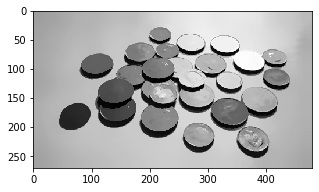

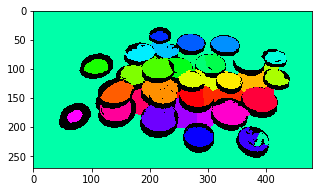

In [76]:
estimate_obj_on_img(estimate_images_path_list[1], shift = True, 
                    spat_radius = 15, color_radius = 45, 
                    blockSize = 55, const = 15, min_distance = 15)

[INFO] 88 unique segments found


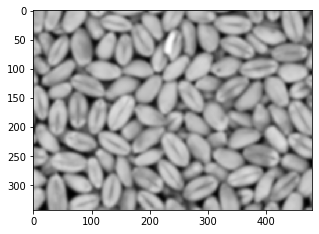

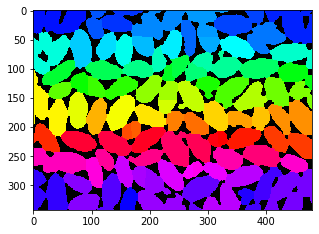

In [80]:
estimate_obj_on_img(estimate_images_path_list[2], shift = False, 
                    blur = True, blur_window_size = 13, 
                    blockSize = 75, const = 35, min_distance = 15)

[INFO] 360 unique segments found


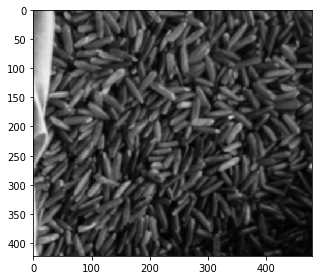

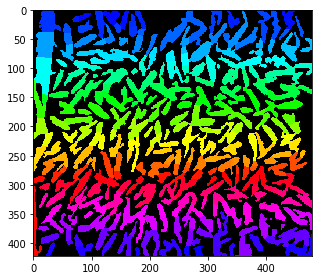

In [81]:
estimate_obj_on_img(estimate_images_path_list[3], shift = False, 
                    blur = True, blur_window_size = 7, 
                    blockSize = 65, const = 4, min_distance = 10)

[INFO] 153 unique segments found


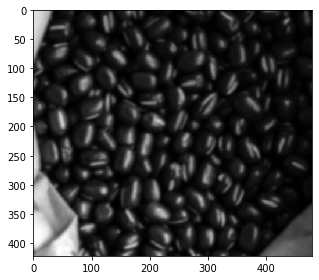

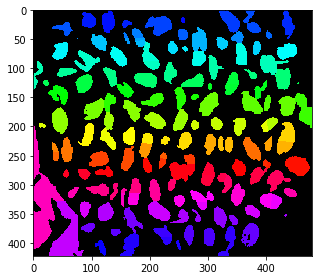

In [82]:
estimate_obj_on_img(estimate_images_path_list[4], shift = False, 
                    blur = True, blur_window_size = 11, 
                    blockSize = 165, const = 5, min_distance = 12)

As with the previous image the part of the bar or container, that the beans are in is treated as separate segment. Since it is treated as only omne segment (and the bottom right part is avoided at all) it is an moderate addition to the general error.

[INFO] 235 unique segments found


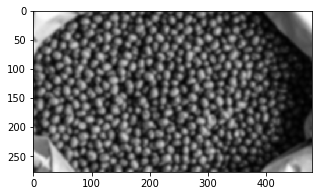

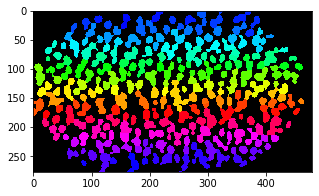

In [89]:
estimate_obj_on_img(estimate_images_path_list[5], shift = False, 
                    blur = True, blur_window_size = 11, 
                    blockSize = 135, const = 8, min_distance = 11)

[INFO] 95 unique segments found


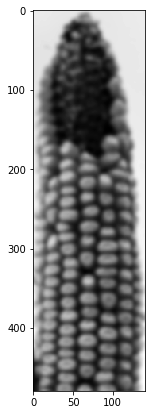

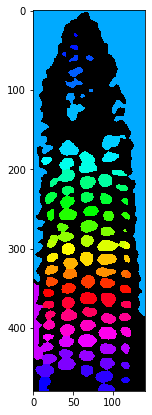

In [107]:
estimate_obj_on_img(estimate_images_path_list[6], shift = False, 
                    blur = True, blur_window_size = 13, 
                    blockSize = 125, const = 5, min_distance = 10)